In [232]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import train_test_split

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets
from IPython.display import display

## Linear regression (cont)

### Polynomial regression

Assume that you are given a dataset that looks like this:
<div style="text-align:center">
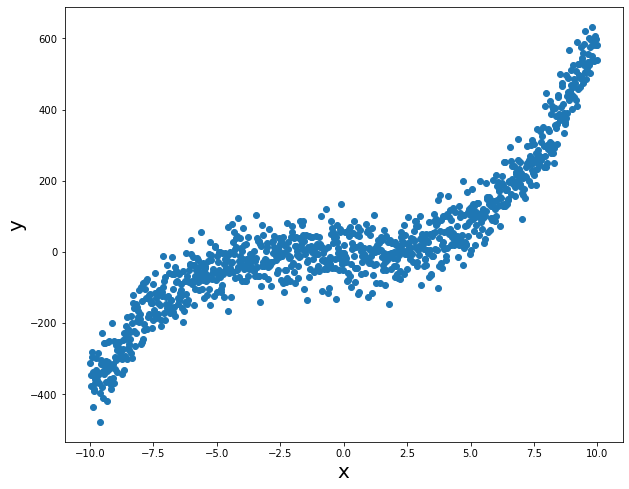
</div>

Your task is to find if there is model that can describe the realtion between $x$ and $y$. 

#### Linear Model

The first step is to try a linear model of the form 
$$
y = \omega_0 + \omega_1x
$$


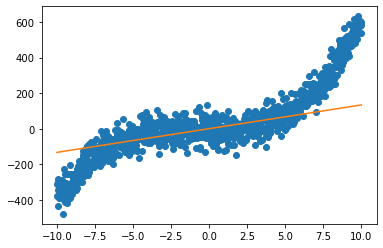

In [228]:
data = pd.read_csv('Data_example1.csv')
x = (data['x'].values).reshape(-1,1)
y = (data['y'].values).reshape(-1,1)

#create X matrix ---- insert your code here
X = np.column_stack((np.ones_like(x),x))

n_iterations = 20
eta = 0.001
w_est = np.zeros((2,n_iterations))
L = np.zeros((n_iterations))

w_est[0,0] = np.random.randn(1,1)
w_est[1,0] = np.random.randn(1,1)

L[0] = (1/2)*np.mean((X@w_est[:,[0]] - y)**2)

for i in range(1,n_iterations):
    #write down the update equation 
    w_old = w_est[:,[i-1]]
    w_new = w_old - (1/len(X))*eta*((X.T)@(X@w_old -y))
    w_est[:,[i]] = w_new
    L[i] = (1/2)*np.mean((X@w_est[:,[i]] - y)**2)


plt.plot(x, y, 'o')
plt.plot(x, X@w_est[:,[-1]])

The result, which should look like this

<div style="text-align:center">
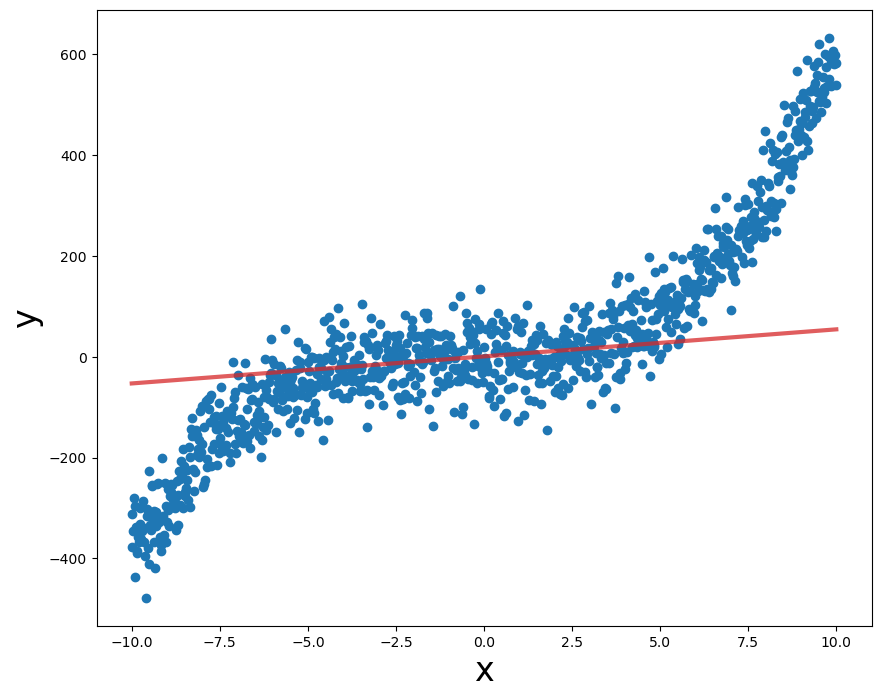
</div>


clearly indicate that that model order is not correct. 

We can propose higher order models or the form 
$$
y = w_0 + w_1 x + w_2 x^2
$$

Let's try gradient Descent with the new model

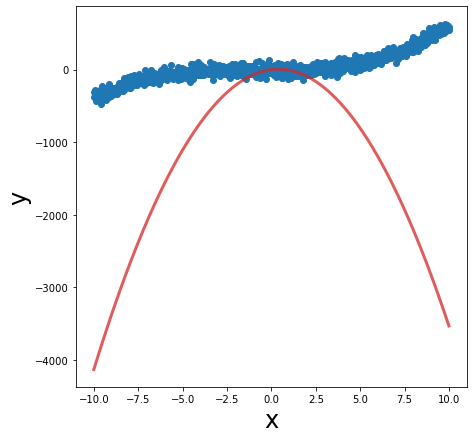

In [230]:
n=2 #model order
data = pd.read_csv('Data_example1.csv')
x = (data['x'].values).reshape(-1,1)
y = (data['y'].values).reshape(-1,1)

#create X matrix for a given order n
X = np.zeros((len(x), n+1))
for i in range(n+1):
    X[:,[i]] = x**i

#Use gradient descent to find the model parameters
 

eta = 0.001; n_iterations=500; w_init=None
w_init =np.random.randn(X.shape[1],1)


L = np.zeros(n_iterations)
w_est = np.zeros((X.shape[1],n_iterations))

w_est[:,[0]] = w_init
L[0] = (1/2)*np.mean((X@w_est[:,[0]] - y)**2)


for i in range(1,n_iterations):
    w_est[:,[i]] = w_est[:,[i-1]] - (1/len(X))*eta*((X.T)@(X@w_est[:,[i-1]]-y))
    L[i] = (1/2)*np.mean((X@w_est[:,[i]] - y)**2)



fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(x,y,'o');
ax.plot(x, X@w_est[:,[-1]], color='tab:red', alpha=0.75, lw=3);
ax.set_ylabel('y', fontsize=24)
ax.set_xlabel('x', fontsize=24)
plt.show();

The output went nuts!

In this case, the columsn of $X$ have very different values 

$$
\begin{bmatrix}
1 & x[0] & x^2[0]  \\
1 & x[1] & x^2[1] \\
1 & x[2] & x^2[2]  \\
\vdots & \vdots & \vdots   \\
1 & x[N] & x^2[N]  \\
\end{bmatrix} = 
\begin{bmatrix}
1 & -10 & 100 \\
1 & -9.97 & 99.6 \\
1 & -9.95 & 99.2  \\
\vdots & \vdots & \vdots \\
1 & 10 & 100  \\
\end{bmatrix} 
$$

and the large difference in values between columns affects the estimated parameters. This is one important limitation of gradient descent, and **you** need to apply manual corrections to make sure that the columns of $X$ have similar values. 

#### Matrix normalization
The goal is that all the columns of the matrix $X$ have similar range of values. That way, one column won't overshadow the other columns. A commonly used normalization procedure is to divide every column by its maximum value, making sure that the maximum value in the columns is one.

```python
normalizer = np.max(X,axis = 0) # takes the maximum of every column
X_normalized = X/normalizer # will divide every column by its maximum 
```


Another common alternative is to make sure that the mean of every column is zero (or some other number) and the standard deviation is 1 (or some other number).

In [234]:
def model_(n):
    data = pd.read_csv('Data_example1.csv')
    x = (data['x'].values).reshape(-1,1)
    y = (data['y'].values).reshape(-1,1)


    #create X matrix for a given order n
    X = np.zeros((len(x), n+1))
    for i in range(n+1):
        X[:,[i]] = x**i

    #normalize the data
    normalizer = np.max(X, axis=0)
    X = X/normalizer
    
    
    #Use gradient descent to find the model parameters


    eta = 0.1; n_iterations=200; w_init=None
    w_init =np.random.randn(X.shape[1],1)


    L = np.zeros(n_iterations)
    w_est = np.zeros((X.shape[1],n_iterations))

    w_est[:,[0]] = w_init
    L[0] = (1/2)*np.mean((X@w_est[:,[0]] - y)**2)


    for i in range(1,n_iterations):
        w_est[:,[i]] = w_est[:,[i-1]] - (1/len(X))*eta*((X.T)@(X@w_est[:,[i-1]]-y))
        L[i] = (1/2)*np.mean((X@w_est[:,[i]] - y)**2)



    fig,ax = plt.subplots(1,1,figsize=(7,7))
    ax.plot(x,y,'o');
    ax.plot(x, X@w_est[:,[-1]], color='tab:red', alpha=0.75, lw=3);
    ax.set_ylabel('y', fontsize=24)
    ax.set_xlabel('x', fontsize=24)
    plt.show();
    
interact(model_, n=IntSlider(min=0, max=30, step=1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='n', max=30), Output()), _dom_cl…

But, how do we know what model order is the best? Clearly from n=3 the predicted data seems _close_ to the measured data, but how do we select the correct order?

#### Model validation/testing 

To evaluate if a model is the right fit for the data, you need to separate your data into __Training__ and __Validation__ sets. you use the training data to find the model parameters, and use the validation data to check if the estimated model is a rigth fit to the data. 
Some sample datasets will provide you with the test and training data; however, in most practical situation you are tasked with creating your own train and test samples. 

Here is how that looks in code 

In [235]:
data = pd.read_csv('Data_example1.csv')
x = (data['x'].values).reshape(-1,1)
y = (data['y'].values).reshape(-1,1)

n = 5
#create X matrix for a given order n
X = np.zeros((len(x), n+1))
for i in range(n+1):
    X[:,[i]] = x**i

#we will take 15% of the data for training 
index = list(range(0,len(x))) #index of all elements in x
random.seed = 42 #defining a seed ensures that the index are repeated every time. Remove this if you are doing a true experiment
test_index = random.sample(index, int(0.15*len(x))) #random sample of elements in x
train_index = list(set(index) - set(test_index)) #remainder index to train the model 


X_train = X[train_index,:]
y_train = y[train_index]

X_test = X[test_index,:]
y_test = y[test_index]

print(f'Lenght X -> {len(X)} data points \nLenght X_train -> {len(X_train)} data points \nLenght X_test -> {len(X_test)} data points')

Lenght X -> 1000 data points 
Lenght X_train -> 850 data points 
Lenght X_test -> 150 data points


Alernatively, you can use sklearn tools for this
```python

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
```

you can use the ```random_state``` input to make sure that the index are repeated every time you run the experiment. If you remove that input, then the index will change every time!

In [236]:
#normalization parameters must be obtained from the train data
normalizer = np.max(X_train, axis=0)
X_train_normalized = X_train/normalizer

#and applied to the test data
X_test_normalized = X_test/normalizer

In [237]:
#Use gradient descent to find the model parameters

def gradient_descent(X_train_normalized,y_train,X_test_normalized,y_test, eta=0.3, n_iterations=200, w_init=None):
    
    """
    This function estimate the parameters of a model using grandient descent.
    You must provide 
    X_train -> Training input data matrix
    y_train -> Training output data
    X_test -> Testing input data matrix
    y_test -> Testing output data 
    
    Optional Parameters:
        eta -> Learning rate (deafaul = 0.3)
        n_iterations -> Number of iterations for gradient descent (default =  200)
        w_init -> Initial parameters estimates (default = samples from a Gaussian distribution )
    """
    
    if w_init is None:
        w_init =np.random.randn(X_train_normalized.shape[1],1)


    L_train = np.zeros(n_iterations)
    L_test = np.zeros(n_iterations)
    w_est = np.zeros((X_train_normalized.shape[1],n_iterations))

    w_est[:,[0]] = w_init

    L_train[0] = (1/2)*np.mean((X_train_normalized@w_est[:,[0]] - y_train)**2)
    L_test[0] = (1/2)*np.mean((X_test_normalized@w_est[:,[0]] - y_test)**2)



    for i in range(1,n_iterations):
        w_est[:,[i]] = w_est[:,[i-1]] - (1/len(X_train_normalized))*eta*((X_train_normalized.T)@(X_train_normalized@w_est[:,[i-1]]-y_train))
        L_train[i] = (1/2)*np.mean((X_train_normalized@w_est[:,[i]] - y_train)**2)
        L_test[i] = (1/2)*np.mean((X_test_normalized@w_est[:,[i]] - y_test)**2)

    return w_est, L_train, L_test


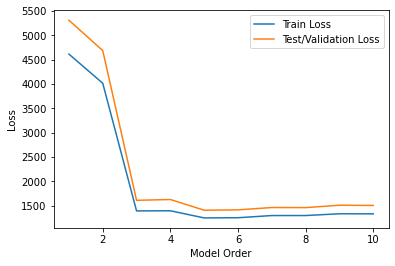

In [238]:
#now, lets see how we can check what is the best model order
data = pd.read_csv('Data_example1.csv')
x = (data['x'].values).reshape(-1,1)
y = (data['y'].values).reshape(-1,1)

#we can check multiple model order in a for-loop 
L_Train = []
L_Test = []
parameters = []

order = list(range(1,11))
for n in order:
    #create X matrix for a given order n
    X = np.zeros((len(x), n+1))
    for i in range(n+1):
        X[:,[i]] = x**i
        
    #split in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    #normalization parameters must be obtained from the train data
    normalizer = np.max(X_train, axis=0)
    X_train_normalized = X_train/normalizer

    #and applied to the test data
    X_test_normalized = X_test/normalizer
    
    w_est, L_train, L_test = gradient_descent(X_train_normalized,y_train,X_test_normalized,y_test)
    
    #store the results obtain for the last iteration in the gradient descent 
    L_Train.append(L_train[-1])
    L_Test.append(L_test[-1])
    parameters.append(w_est[:,[-1]])

plt.plot(order,L_Train, label='Train Loss')
plt.plot(order,L_Test, label = 'Test/Validation Loss')
plt.xlabel('Model Order')
plt.ylabel('Loss')
plt.legend()
plt.show()

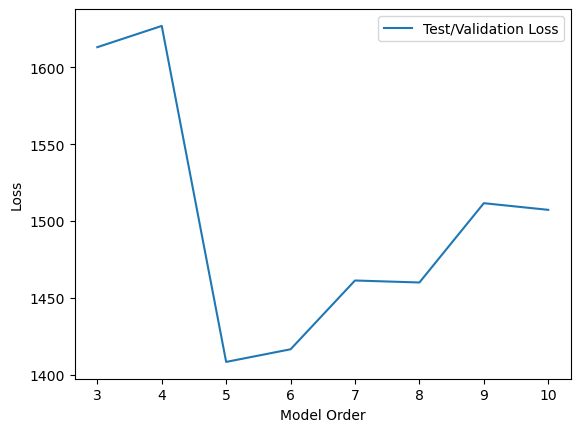

In [172]:
#We can take a closer look
plt.plot(order[2:],L_Test[2:], label = 'Test/Validation Loss')
plt.xlabel('Model Order')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Mini-batch gradient descent 

One of the most important modifications to the classical gradient descent algorith, is to use only small samples of data to compute the model parameters. Ater using the first small sample of data, you repeat the GD algorithm with another small sample and using the result from the previous iteration as initial values 

In [173]:
def create_mini_batches(X, y, batch_size):
    #split the data into random mini-batches
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
  
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

In [186]:
data = pd.read_csv('Data_example1.csv')
x = (data['x'].values).reshape(-1,1)
y = (data['y'].values).reshape(-1,1)

n = 5
#create X matrix for a given order n
X = np.zeros((len(x), n+1))
for i in range(n+1):
    X[:,[i]] = x**i

#split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

number_of_batches = 20
data_in_batches = create_mini_batches(X_train, y_train, number_of_batches)
w_est_batch = []
L_train_batch = []
L_test_batch = []
for epoch, mini_batch in enumerate(data_in_batches):
    X_mini, y_mini = mini_batch
    normalizer = np.max(X_mini, axis=0)
    X_mini_normalized = X_mini/normalizer
    
    X_test_normalized = X_test/normalizer
    
    if epoch == 0: #first time, parameters are random 
        
        w_est, L_train, L_test = gradient_descent(X_mini_normalized,y_mini,X_test_normalized,y_test)
        
    else: #use results from previous mini-batch 
        
        w_est, L_train, L_test = gradient_descent(X_mini_normalized,y_mini,X_test_normalized,y_test, w_init = w_est[:,[-1]])
        
    w_est_batch.append(w_est[:,[-1]])
    L_train_batch.append(L_train[-1])

<ipython-input-177-c1ce5a18ebcc>:36: RuntimeWarning: overflow encountered in square
  L_train[i] = (1/2)*np.mean((X_train_normalized@w_est[:,[i]] - y_train)**2)
<ipython-input-177-c1ce5a18ebcc>:37: RuntimeWarning: overflow encountered in square
  L_test[i] = (1/2)*np.mean((X_test_normalized@w_est[:,[i]] - y_test)**2)
<ipython-input-177-c1ce5a18ebcc>:35: RuntimeWarning: overflow encountered in matmul
  w_est[:,[i]] = w_est[:,[i-1]] - (1/len(X_train_normalized))*eta*((X_train_normalized.T)@(X_train_normalized@w_est[:,[i-1]]-y_train))
<ipython-input-177-c1ce5a18ebcc>:35: RuntimeWarning: invalid value encountered in matmul
  w_est[:,[i]] = w_est[:,[i-1]] - (1/len(X_train_normalized))*eta*((X_train_normalized.T)@(X_train_normalized@w_est[:,[i-1]]-y_train))
<ipython-input-177-c1ce5a18ebcc>:35: RuntimeWarning: invalid value encountered in subtract
  w_est[:,[i]] = w_est[:,[i-1]] - (1/len(X_train_normalized))*eta*((X_train_normalized.T)@(X_train_normalized@w_est[:,[i-1]]-y_train))


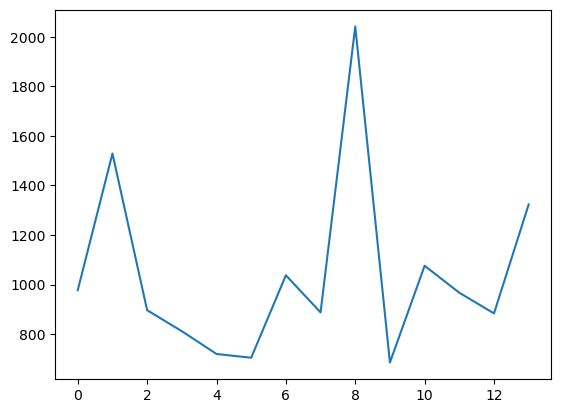

In [187]:
plt.plot(L_train_batch);plt.show()

In [154]:
mini_batches = create_mini_batches(X_train, y_train, 50)
mini_batches_X, mini_batches_y = mini_batches

ValueError: too many values to unpack (expected 2)

In [152]:
mini_batches 

[(array([[ 1.00000000e+00,  6.70670671e-01,  4.49799148e-01,
           3.01667097e-01,  2.02319274e-01,  1.35689603e-01,
           9.10030372e-02,  6.10330680e-02,  4.09330886e-02,
           2.74526220e-02,  1.84116684e-02],
         [ 1.00000000e+00,  3.55355355e+00,  1.26277429e+01,
           4.48733605e+01,  1.59459890e+02,  5.66649258e+02,
           2.01361848e+03,  7.15550112e+03,  2.54274564e+04,
           9.03578281e+04,  3.21091381e+05],
         [ 1.00000000e+00, -1.11111111e+00,  1.23456790e+00,
          -1.37174211e+00,  1.52415790e+00, -1.69350878e+00,
           1.88167642e+00, -2.09075158e+00,  2.32305731e+00,
          -2.58117479e+00,  2.86797199e+00],
         [ 1.00000000e+00, -6.90690691e-01,  4.77053630e-01,
          -3.29496501e-01,  2.27580166e-01, -1.57187502e-01,
           1.08567944e-01, -7.49868685e-02,  5.17927320e-02,
          -3.57727578e-02,  2.47079108e-02],
         [ 1.00000000e+00,  5.33533534e+00,  2.84658031e+01,
           1.51874605e+02, 